In [1]:
# !pip install kaggle
# !kaggle datasets download -p dataset/ --unzip cpanag/aifloodsense

In [2]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode
import random
from torch import nn
from tqdm import tqdm
from torchmetrics import JaccardIndex

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
classes_info = pd.DataFrame({
    'class': ['background', 'flood', 'sky', 'building'],
    'grayscale_value': [0, 255, 170, 85],
    'class_index': [0, 1, 2, 3]
})

classes_info

,class,grayscale_value,class_index
0,background,0,0
1,flood,255,1
2,sky,170,2
3,building,85,3


In [5]:
TRAIN_IMAGES_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'train', 'images')
TRAIN_MASKS_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'train', 'masks')
VAL_IMAGES_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'test', 'images')
VAL_MASKS_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'test', 'masks')

In [6]:
for image_name in os.listdir(TRAIN_IMAGES_PATH):
    image_path = os.path.join(TRAIN_IMAGES_PATH, image_name)
    mask_name = image_name.split('.')[0] + '.png'
    mask_path = os.path.join(TRAIN_MASKS_PATH, mask_name)

image_path, mask_path

('dataset/AIFloodSense/AIFloodSense/train/images/157.jpg',
 'dataset/AIFloodSense/AIFloodSense/train/masks/157.png')

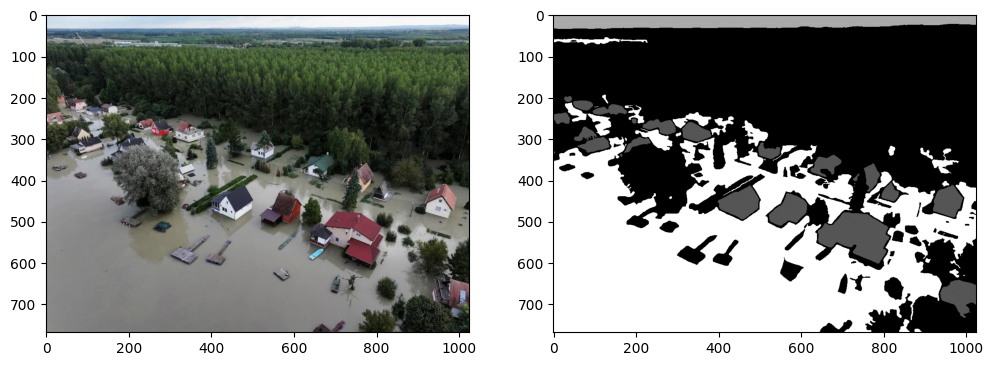

In [7]:
image = Image.open(image_path)
mask = Image.open(mask_path)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')

In [8]:
mask_np = np.array(mask)
np.unique(mask_np)

array([  0,  85, 170, 255], dtype=uint8)

In [9]:
def color_to_index(mask):
    mask_indexes = []

    for color in classes_info['grayscale_value'].values:
        mask_indexes.append(torch.where(mask == color, 1, 0).tolist())

    return torch.tensor(mask_indexes).argmax(dim=0)

In [10]:
color_to_index(torch.tensor(mask_np)).unique()

tensor([0, 1, 2, 3])

In [11]:
IMAGE_SIZE = 448

train_transforms = {
    'image': v2.Compose([
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.ToDtype(torch.float, scale=True)
    ]),
    'mask': v2.Compose([
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=InterpolationMode.NEAREST_EXACT),
        v2.ToDtype(torch.long, scale=False)
    ])
}

val_transforms = {
    'image': v2.Compose([
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.ToDtype(torch.float, scale=True)
    ]),
    'mask': v2.Compose([
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=InterpolationMode.NEAREST_EXACT),
        v2.ToDtype(torch.long, scale=False)
    ])
}

In [12]:
class FloodsDataset(Dataset):
    def __init__(self, images_path, masks_path, transforms):
        super().__init__()
        self.images_pathes = []
        self.masks_pathes = []
        self.transforms = transforms

        for image_name in os.listdir(images_path):
            image_path = os.path.join(images_path, image_name)
            mask_name = image_name.split('.')[0] + '.png'
            mask_path = os.path.join(masks_path, mask_name)
            self.images_pathes.append(image_path)
            self.masks_pathes.append(mask_path)

    def __len__(self):
        return len(self.images_pathes)

    def __getitem__(self, index):
        image_path = self.images_pathes[index]
        mask_path = self.masks_pathes[index]
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        transformed_image = self.transforms['image'](image)
        transformed_mask = self.transforms['mask'](mask)
        indexed_mask = color_to_index(transformed_mask.squeeze())
        return transformed_image, indexed_mask

In [13]:
train_ds = FloodsDataset(TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, train_transforms)
val_ds = FloodsDataset(VAL_IMAGES_PATH, VAL_MASKS_PATH, val_transforms)
len(train_ds), len(val_ds)

(376, 94)

tensor([0, 1, 2, 3])


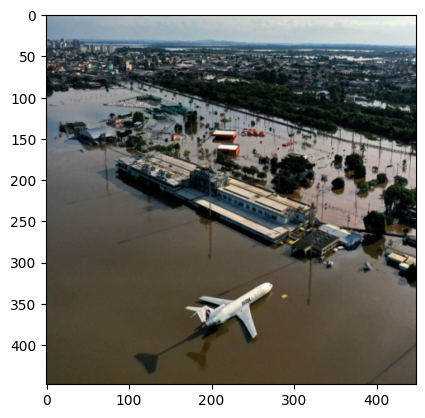

In [14]:
random_index = random.randint(0, len(train_ds) - 1)
random_image = train_ds[random_index][0]
random_mask = train_ds[random_index][1]
print(random_mask.unique())
plt.imshow(random_image.permute(1, 2, 0))


In [15]:
BATCH_SIZE = 16

train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [16]:
for batch in train_loader:
    images = batch[0]
    image_sample = images[0]
    masks = batch[1]
    mask_sample = masks[0]
    break

tensor([0, 1, 3])


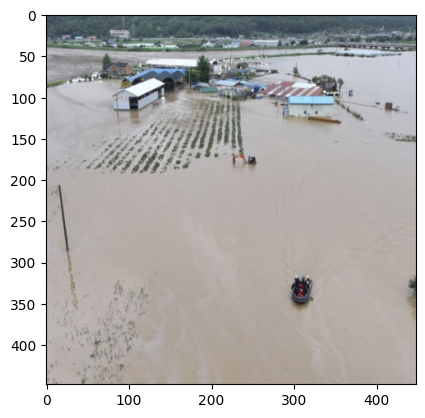

In [17]:
print(mask_sample.unique())
plt.imshow(image_sample.permute(1, 2, 0))

In [18]:
mask_sample.shape

torch.Size([448, 448])

In [19]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu'
device

device(type='cuda')

In [20]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, first_block=False):
        super().__init__()
        if first_block:
            out_channels = 32
        else:
            out_channels = in_channels * 2

        self.act = nn.ReLU()
        self.norm = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding='same')

    def forward(self, batch):
        normalized = self.norm(batch)
        conv1 = self.conv1(normalized)
        conv1_act = self.act(conv1)
        conv2 = self.conv2(conv1_act)
        conv2_act = self.act(conv2)
        return conv2_act

In [21]:
class DecoderBlock(nn.Module):
    def __init__(self, encoder_channels, decoder_channels):
        super().__init__()
        in_channels = encoder_channels + decoder_channels
        out_channels = decoder_channels // 2

        self.upconv = nn.ConvTranspose2d(decoder_channels, decoder_channels, 2, 2)
        self.act = nn.ReLU()
        self.norm = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, decoder_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(decoder_channels, out_channels, 3, padding='same')
        self.conv3 = nn.Conv2d(out_channels, out_channels, 3, padding='same')

    def forward(self, encoder, decoder):
        upconved = self.upconv(decoder)
        concatenated = torch.concat([encoder, upconved], dim=1)
        normalized = self.norm(concatenated)
        conv1 = self.conv1(normalized)
        conv1_act = self.act(conv1)
        conv2 = self.conv2(conv1_act)
        conv2_act = self.act(conv2)
        conv3 = self.conv3(conv2_act)
        conv3_act = self.act(conv3)
        return conv3_act

In [22]:
class CustomUNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.pooling = nn.MaxPool2d(2, 2)
        self.encoder1 = EncoderBlock(3, True)
        self.encoder2 = EncoderBlock(32)
        self.encoder3 = EncoderBlock(64)
        self.encoder4 = EncoderBlock(128)
        self.encoder5 = EncoderBlock(256)
        self.encoder6 = EncoderBlock(512)
        self.decoder1 = DecoderBlock(512, 1024)
        self.decoder2 = DecoderBlock(256, 512)
        self.decoder3 = DecoderBlock(128, 256)
        self.decoder4 = DecoderBlock(64, 128)
        self.decoder5 = DecoderBlock(32, 64)
        self.last_conv = nn.Conv2d(32, num_classes, 1)

    def forward(self, batch):
        encoder1 = self.encoder1(batch)
        encoder1_pool = self.pooling(encoder1)
        encoder2 = self.encoder2(encoder1_pool)
        encoder2_pool = self.pooling(encoder2)
        encoder3 = self.encoder3(encoder2_pool)
        encoder3_pool = self.pooling(encoder3)
        encoder4 = self.encoder4(encoder3_pool)
        encoder4_pool = self.pooling(encoder4)
        encoder5 = self.encoder5(encoder4_pool)
        encoder5_pool = self.pooling(encoder5)
        encoder6 = self.encoder6(encoder5_pool)
        decoder1 = self.decoder1(encoder5, encoder6)
        decoder2 = self.decoder2(encoder4, decoder1)
        decoder3 = self.decoder3(encoder3, decoder2)
        decoder4 = self.decoder4(encoder2, decoder3)
        decoder5 = self.decoder5(encoder1, decoder4)
        output = self.last_conv(decoder5)
        return output

In [23]:
model = CustomUNet(len(classes_info))
model(batch[0]).shape

torch.Size([16, 4, 448, 448])

In [24]:
model.to(device)

CustomUNet(
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder1): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder2): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder3): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder4

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
jaccard_index = JaccardIndex('multiclass', num_classes=len(classes_info)).to(device)

In [26]:
def train(model, loader, loss_fn, optimizer):
    iou_sum = 0
    loss_sum = 0

    model.train()
    for X, Y in tqdm(loader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, Y)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1)
        iou_sum += jaccard_index(pred, Y).item()
        loss_sum += loss.item()

    return iou_sum / len(loader), loss_sum / len(loader)

In [27]:
def evaluate(model, loader, loss_fn):
    iou_sum = 0
    loss_sum = 0

    model.eval()
    with torch.no_grad():
        for X, Y in tqdm(loader):
            X, Y = X.to(device), Y.to(device)
            output = model(X)
            loss = loss_fn(output, Y)
            pred = output.argmax(dim=1)
            iou_sum += jaccard_index(pred, Y).item()
            loss_sum += loss.item()

    return iou_sum / len(loader), loss_sum / len(loader)

In [28]:
EPOCHS = 25
train_losses = []
train_metrics = []
val_losses = []
val_metrics = []
min_val_loss = None

for epoch in range(1, EPOCHS + 1):
    print('-' * 10)
    print(f'Epoch {epoch}:')
    train_iou, train_loss = train(model, train_loader, loss_fn, optimizer)
    train_metrics.append(train_iou)
    train_losses.append(train_loss)
    print(f'Train IoU: {train_iou}')
    print(f'Train loss: {train_loss}')
    val_iou, val_loss = evaluate(model, val_loader, loss_fn)
    val_metrics.append(val_iou)
    val_losses.append(val_loss)
    print(f'Val IoU: {val_iou}')
    print(f'Val loss: {val_loss}')
    lr_scheduler.step(val_loss)

    if not min_val_loss or min_val_loss > val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'models/best_params.pt')
        print('Best model saved')

----------
Epoch 1:


100%|██████████| 24/24 [01:47<00:00,  4.46s/it]


Train IoU: 0.1580637626660367
Train loss: 1.36699012418588


100%|██████████| 6/6 [00:21<00:00,  3.65s/it]


Val IoU: 0.1309783235192299
Val loss: 1.4066047469774883
Best model saved
----------
Epoch 2:


100%|██████████| 24/24 [01:42<00:00,  4.29s/it]


Train IoU: 0.319002240896225
Train loss: 0.8918750410278639


100%|██████████| 6/6 [00:21<00:00,  3.64s/it]


Val IoU: 0.26157984634240466
Val loss: 0.9017377098401388
Best model saved
----------
Epoch 3:


100%|██████████| 24/24 [01:43<00:00,  4.30s/it]


Train IoU: 0.33914590751131374
Train loss: 0.641926987717549


100%|██████████| 6/6 [00:21<00:00,  3.66s/it]


Val IoU: 0.4001452873150508
Val loss: 0.6792062421639761
Best model saved
----------
Epoch 4:


100%|██████████| 24/24 [01:43<00:00,  4.30s/it]


Train IoU: 0.4746081543465455
Train loss: 0.6090552794436613


100%|██████████| 6/6 [00:21<00:00,  3.59s/it]


Val IoU: 0.46125607192516327
Val loss: 0.6674413979053497
Best model saved
----------
Epoch 5:


100%|██████████| 24/24 [01:43<00:00,  4.30s/it]


Train IoU: 0.4781850216289361
Train loss: 0.5709680368502935


100%|██████████| 6/6 [00:21<00:00,  3.62s/it]


Val IoU: 0.4524787614742915
Val loss: 0.6102339128653208
Best model saved
----------
Epoch 6:


100%|██████████| 24/24 [01:41<00:00,  4.25s/it]


Train IoU: 0.5481774210929871
Train loss: 0.5370918909708658


100%|██████████| 6/6 [00:21<00:00,  3.59s/it]


Val IoU: 0.56870170434316
Val loss: 0.5886798252662023
Best model saved
----------
Epoch 7:


100%|██████████| 24/24 [01:42<00:00,  4.25s/it]


Train IoU: 0.6007098915676276
Train loss: 0.5053498037159443


100%|██████████| 6/6 [00:21<00:00,  3.58s/it]


Val IoU: 0.5911784072717031
Val loss: 0.5511149764060974
Best model saved
----------
Epoch 8:


100%|██████████| 24/24 [01:41<00:00,  4.24s/it]


Train IoU: 0.6279036973913511
Train loss: 0.4715132862329483


100%|██████████| 6/6 [00:21<00:00,  3.62s/it]


Val IoU: 0.5795296082894007
Val loss: 0.5573439002037048
----------
Epoch 9:


100%|██████████| 24/24 [01:41<00:00,  4.23s/it]


Train IoU: 0.6271305816868941
Train loss: 0.469814196228981


100%|██████████| 6/6 [00:21<00:00,  3.61s/it]


Val IoU: 0.6360311309496561
Val loss: 0.5098358541727066
Best model saved
----------
Epoch 10:


100%|██████████| 24/24 [01:41<00:00,  4.24s/it]


Train IoU: 0.6683101331194242
Train loss: 0.4387045775850614


100%|██████████| 6/6 [00:21<00:00,  3.54s/it]


Val IoU: 0.617019404967626
Val loss: 0.5416110455989838
----------
Epoch 11:


100%|██████████| 24/24 [01:41<00:00,  4.25s/it]


Train IoU: 0.6660833582282066
Train loss: 0.42122217640280724


100%|██████████| 6/6 [00:21<00:00,  3.56s/it]


Val IoU: 0.6417211989561716
Val loss: 0.4843393365542094
Best model saved
----------
Epoch 12:


100%|██████████| 24/24 [01:41<00:00,  4.23s/it]


Train IoU: 0.6709932213028272
Train loss: 0.4191846139729023


100%|██████████| 6/6 [00:21<00:00,  3.62s/it]


Val IoU: 0.633685290813446
Val loss: 0.5143613417943319
----------
Epoch 13:


100%|██████████| 24/24 [01:42<00:00,  4.26s/it]


Train IoU: 0.6682553887367249
Train loss: 0.421690434217453


100%|██████████| 6/6 [00:21<00:00,  3.59s/it]


Val IoU: 0.6667514642079672
Val loss: 0.475429763396581
Best model saved
----------
Epoch 14:


100%|██████████| 24/24 [01:41<00:00,  4.25s/it]


Train IoU: 0.6854298189282417
Train loss: 0.39876101290186244


100%|██████████| 6/6 [00:21<00:00,  3.57s/it]


Val IoU: 0.6719752550125122
Val loss: 0.4551481952269872
Best model saved
----------
Epoch 15:


100%|██████████| 24/24 [01:41<00:00,  4.23s/it]


Train IoU: 0.6986004908879598
Train loss: 0.3792342854042848


100%|██████████| 6/6 [00:21<00:00,  3.61s/it]


Val IoU: 0.6730903883775076
Val loss: 0.46477896471818286
----------
Epoch 16:


100%|██████████| 24/24 [01:41<00:00,  4.22s/it]


Train IoU: 0.7038563390572866
Train loss: 0.3770102721949418


100%|██████████| 6/6 [00:21<00:00,  3.57s/it]


Val IoU: 0.6578237315018972
Val loss: 0.489442636569341
----------
Epoch 17:


100%|██████████| 24/24 [01:41<00:00,  4.24s/it]


Train IoU: 0.6970997701088587
Train loss: 0.379672488818566


100%|██████████| 6/6 [00:21<00:00,  3.55s/it]


Val IoU: 0.6663059790929159
Val loss: 0.4555378605922063
----------
Epoch 18:


100%|██████████| 24/24 [01:41<00:00,  4.23s/it]


Train IoU: 0.7153526941935221
Train loss: 0.3530445198218028


100%|██████████| 6/6 [00:21<00:00,  3.63s/it]


Val IoU: 0.6852719088395437
Val loss: 0.4369972050189972
Best model saved
----------
Epoch 19:


100%|██████████| 24/24 [01:40<00:00,  4.21s/it]


Train IoU: 0.7250156104564667
Train loss: 0.33605243513981503


100%|██████████| 6/6 [00:21<00:00,  3.55s/it]


Val IoU: 0.6810487111409506
Val loss: 0.4531948318084081
----------
Epoch 20:


100%|██████████| 24/24 [01:41<00:00,  4.25s/it]


Train IoU: 0.7294169490536054
Train loss: 0.33530022017657757


100%|██████████| 6/6 [00:21<00:00,  3.59s/it]


Val IoU: 0.6877046426137289
Val loss: 0.4409622500340144
----------
Epoch 21:


100%|██████████| 24/24 [01:41<00:00,  4.23s/it]


Train IoU: 0.7397449438770612
Train loss: 0.32738228887319565


100%|██████████| 6/6 [00:21<00:00,  3.59s/it]


Val IoU: 0.6931191186110178
Val loss: 0.4311694751183192
Best model saved
----------
Epoch 22:


100%|██████████| 24/24 [01:40<00:00,  4.17s/it]


Train IoU: 0.7510935217142105
Train loss: 0.31761429210503894


100%|██████████| 6/6 [00:21<00:00,  3.65s/it]


Val IoU: 0.6910421152909597
Val loss: 0.44014305373032886
----------
Epoch 23:


100%|██████████| 24/24 [01:42<00:00,  4.25s/it]


Train IoU: 0.7471845100323359
Train loss: 0.31148620632787544


100%|██████████| 6/6 [00:21<00:00,  3.57s/it]


Val IoU: 0.6943178574244181
Val loss: 0.4391344537337621
----------
Epoch 24:


100%|██████████| 24/24 [01:43<00:00,  4.32s/it]


Train IoU: 0.7582555661598841
Train loss: 0.3092751329143842


100%|██████████| 6/6 [00:22<00:00,  3.68s/it]


Val IoU: 0.6951516767342886
Val loss: 0.43565156559149426
----------
Epoch 25:


100%|██████████| 24/24 [01:41<00:00,  4.23s/it]


Train IoU: 0.7542641013860703
Train loss: 0.31056830659508705


100%|██████████| 6/6 [00:21<00:00,  3.56s/it]

Val IoU: 0.6955387691656748
Val loss: 0.4402310401201248


In [29]:
lr_scheduler.get_last_lr()

[1.0000000000000002e-06]

Text(0.5, 1.0, "IoU's")

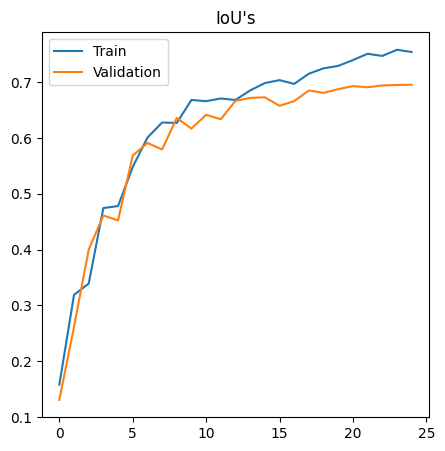

In [30]:
plt.figure(figsize=(5, 5))
plt.plot(train_metrics, label='Train')
plt.plot(val_metrics, label='Validation')
plt.legend()
plt.title('IoU\'s')

Text(0.5, 1.0, 'Losses')

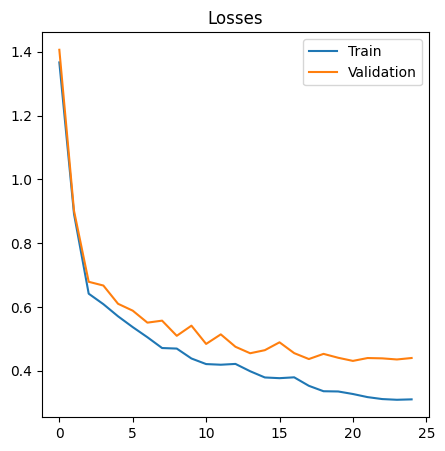

In [31]:
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.title('Losses')

In [32]:
model = CustomUNet(len(classes_info))
model.load_state_dict(torch.load('models/best_params.pt', weights_only=True))
model.eval()
model.to(device)

CustomUNet(
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder1): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder2): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder3): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder4

In [33]:
def index_to_color(mask):
    mask_colors = []

    for index in range(len(classes_info)):
        color = classes_info[classes_info['class_index'] == index]['grayscale_value'].item()
        mask_colors.append(torch.where(mask == index, color, 0).tolist())

    return torch.tensor(mask_colors).max(dim=0).values

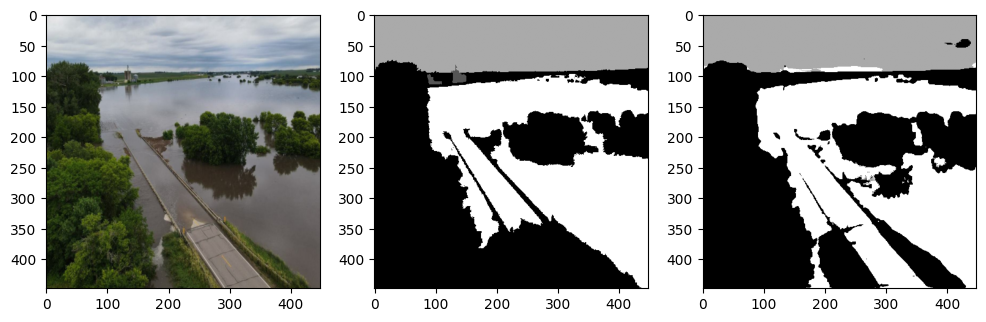

In [34]:
test_index = random.randint(0, len(train_ds) - 1)
test_image = train_ds[test_index][0]
test_mask = train_ds[test_index][1]
test_pred = model(test_image.unsqueeze(0).to(device))[0].argmax(dim=0)
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(test_image.permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.imshow(index_to_color(test_mask), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(index_to_color(test_pred), cmap='gray')